In [94]:
#prepei na einai egkatesthmena
#pip install gurobipy
#pip install numpy
#pip install pandas
#pip install pyomo

#                    Σταύρος Βασίλειος Μπουλιόπουλος 9671 
#                  Δεύτερο πρόβλημα Επιχειρησιακής Έρευνας
Δεύτερο πρόβλημα Επιχειρησιακής Έρευνας για το εργοστάσιο χρωματισμού ταπετσαριών.

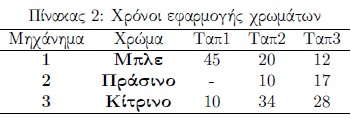





## Problem definition
Συμβολίζουμε την χρονική περίοδο εκτέλεσης μιας διαδικασίας $(j,m)$ με $T_{j,m}$ και την διαδικασία $(k,n) = Πρώην_{j,m}$ που πρέπει να εκτελεστεί πριν την διαδικασία $(j,m)$. Ορίζουμε ως μεταβλητές απόφασης την $Αρχή_{j,m}$,που δηλώνει την αρχή μιας διαδικασίας $(j,m)$ και την $makespan$ ,που δηλώνει τον χρόνο ολοκλήρωσης όλων των διαδικασιών και είναι μια υποψήφια αντικειμενική συνάρτηση. 
## Objective function
Ορίζουμε ως μεταβλητές απόφασης την $Αρχή_{j,m}$,που δηλώνει την αρχή μιας διαδικασίας $(j,m)$ και την $makespan$ ,που δηλώνει τον χρόνο ολοκλήρωσης όλων των διαδικασιών και είναι μια υποψήφια αντικειμενική συνάρτηση. 

## Constraints-s.t.
Έχουμε ένα κάτω φράγμα ως προς την αρχή της διαδικασίας $(j,m)$: $Αρχή_{j,m} \ge 0$
και ομοίως ένα άνω φράγμα: $Αρχή_{j,m} + T_{j,m} \le makespan$.
Κάθε προηγούμενη διαδικασία $(k,n)$ πρέπει να ολοκληρώνεται πριν ξεκινήσει άλλη διαδικασία $(j,m)$: $Αρχή_{k,n} + T_{k,n} \le Αρχή_{j,m}$ 
,όπου $(k,n)= Πρώην_{j,m}$.
Τέλος, για κάθε διαδικασία χρωματισμού, που αναλαμβάνει ένα μηχάνημα $m$, δεν μπορεί να υπάρχει χρονική επικάλυψη μεταξύ αυτών των διαδικασιών.Αναλυτικότερα, οδηγούμαστε σε ένα σύνολο διαχωριστικών περιορισμών ανά ζεύγη για κάθε μηχάνημα και θέλουμε να αποφύγουμε τις συγκρούσεις ταυτόχρονης χρήσης του ίδιου μηχανήματος: $[Αρχή_{j,m} + T_{j,m} \le Αρχή_{k,m}] \vee [Αρχή_{k,m} + T_{k,m} \le Αρχή_{j,m}]$ 


In [101]:
from pyomo.environ import *
from pyomo.gdp import *
#pandas gia thn  eupepth probolh se dataframe
import pandas as pd


#pinakas t pou exei ta dedomena tou problhmatos ws pros tis xronikes ekteleseis
#kai thn akolou8ia xrwmatismou gia thn oloklhrwsh mias tapetsarias 
t = {
    ('Tapetsaria_1','Mple')   : {'T': 45, 'prwhn': None},
    ('Tapetsaria_1','Kitrino') : {'T': 10, 'prwhn': ('Tapetsaria_1','Mple')},
    ('Tapetsaria_2','Mple')   : {'T': 20, 'prwhn': ('Tapetsaria_2','Prasino')},
    ('Tapetsaria_2','Prasino')  : {'T': 10, 'prwhn': None},
    ('Tapetsaria_2','Kitrino') : {'T': 34, 'prwhn': ('Tapetsaria_2','Mple')},
    ('Tapetsaria_3','Mple')   : {'T': 12, 'prwhn': ('Tapetsaria_3','Kitrino')},
    ('Tapetsaria_3','Prasino')  : {'T': 17, 'prwhn': ('Tapetsaria_3','Mple')},
    ('Tapetsaria_3','Kitrino') : {'T': 28, 'prwhn': None},   
}



def job_model(t):
    #problhma job shop scheduling opou exoume 3mhxanhmata , 3 proionta-tapetsaries  kai 3 proionta exoun sygkekrimeno motibo TASKORDER background->sxedio1->sxedio2
    model = ConcreteModel()
    model.t = Set(initialize = t.keys(), dimen=2)
    
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.t])))
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.t])))
    
    model.TASKORDER = Set(initialize = model.t * model.t, dimen=4, 
        filter = lambda model, j, m, k, n: (k,n) == t[(j,m)]['prwhn'])
    
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j < k and (j,m) in model.t and (k,m) in model.t)
    
    model.T = Param(model.t, initialize=lambda model, j, m: t[(j,m)]['T'])
    
    ub = sum([model.T[j, m] for (j,m) in model.t])
    model.makespan = Var(bounds=(0, ub))
    model.arxh = Var(model.t, bounds=(0, ub))
    model.objective = Objective(expr = model.makespan, sense = minimize)
    
    model.telos = Constraint(model.t, rule=lambda model, j, m:  
        model.arxh[j,m] + model.T[j,m] <= model.makespan)
    model.prwhneding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n: 
        model.arxh[k,n] + model.T[k,n] <= model.arxh[j,m])
    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.arxh[j,m] + model.T[j,m] <= model.arxh[k,m], 
         model.arxh[k,m] + model.T[k,m] <= model.arxh[j,m]])
    TransformationFactory('gdp.hull').apply_to(model)
    return model

job_model(t)

def job_solve(model):
    SolverFactory('gurobi').solve(model)
    results = [{'Tapetsaria': j,
                'Xrwma': m,
                'Arxh': model.arxh[j, m](), 
                'Diarkeia': model.T[j,m], 
                'Telos': model.arxh[(j, m)]() + model.T[j,m]}
               for j,m in model.t]
    return results

def job(t):
    return job_solve(job_model(t))

results = job(t)
results

schedule = pd.DataFrame(results)

print('\nXronodiagramma paragwghs tapetsariwn sto ergostasio')
print(schedule.sort_values(by=['Tapetsaria','Arxh']).set_index(['Tapetsaria', 'Xrwma']))



Xronodiagramma paragwghs tapetsariwn sto ergostasio
                      Arxh  Diarkeia  Telos
Tapetsaria   Xrwma                         
Tapetsaria_1 Mple     42.0        45   87.0
             Kitrino  87.0        10   97.0
Tapetsaria_2 Prasino   0.0        10   10.0
             Mple     10.0        20   30.0
             Kitrino  30.0        34   64.0
Tapetsaria_3 Kitrino   0.0        28   28.0
             Mple     30.0        12   42.0
             Prasino  42.0        17   59.0


## Αγνοήστε τα παρακάτω καθώς ήταν πειράματα με gurobipy βιβλιοθήκη, τα οποία δεν δούλεψαν εν τέλει και επέλεξα να το κάνω με Pyomo όπως έδειξα πάνω

In [102]:
from gurobipy import *
import numpy as np
import pandas as pd
#mhxanes xrwmatwn gia ka8e xrwma 1mple,2prasino,3kitrino
machines = (1,2,3)
#tapetsaries tap1,tap2,tap3
products = (1,2,3)

#akolou8ia bapsimatos tapetsariwn: background->sxedio1->sxedio2 ={Xrwmata: [apo mhxanhma i, apo mhxanhma j,apo k.o.k.]}
sequence = {1:[1,3],2:[2,1,3],3:[3,1,2]}
#sequence = {1:[1,3],2:[1,2,3],3:[1,2,3]}
#pinakas xronwn (tapetsaria,mhxanhma)
t={(1,1): 45,
   (1,3): 10,
   (2,1): 20,
   (2,2): 10,
   (2,3): 34,
   (3,1): 12,
   (3,2): 17,
   (3,3): 28}

edges=[(i,j) for i in products for j in sequence[i]]
edges
#montelopoihsh
model = Model('prob2')

x = model.addVars(edges,vtype = GRB.INTEGER,name = 'x')
opt = model.addVars(edges,vtype = GRB.BINARY,name = 'opt')
y = model.addVar(vtype = GRB.INTEGER,name = 'y')

for p in products:
    for m in range(len(sequence[p])-1):
        i = sequence[p][m]
        j = sequence[p][m+1]
        model.addConstr((x[p,i]+t[p,i]) <= x[p,j])

edges_machine = sorted(edges, key=lambda tup: tup[1])
for m in edges_machine:
    schedule_list = [n for n in edges_machine if n != m and n[1] == m[1]]
    for s in schedule_list:
        model.addConstr((opt[m] == 1) >> ((x[m]+t[m]) <= x[s]))
        model.addConstr(opt[m]+opt[s] == 1)
        
#makespan
for i in products:
    model.addConstr(y >= x[i,sequence[i][-1]]+t[i,sequence[i][-1]])

#antikeimenikh synarthsh gia elaxistopoihsh kostous
model.setObjective(y,GRB.MINIMIZE)
model.optimize()
#model.computeIIS() 



import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

#MPLE PRASINO  KITRINO
#1884F1 #3DD322 #F4F120

schedule1 = ['Mhxanh1','Mhxanh3']
color1 = ['#1884F1','#F4F120']

schedule2 = ['Mhxanh1','Mhxanh2','Mhxanh3']
color2 = ['#1884F1','#3DD322','#F4F120']

schedule3 = ['Mhxanh1','Mhxanh2','Mhxanh3']
color3 = ['#1884F1','#3DD322','#F4F120']
#1884F1 #3DD322 #F4F120

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 22 rows, 17 columns and 44 nonzeros
Model fingerprint: 0xfa6dfd17
Model has 14 general constraints
Variable types: 0 continuous, 17 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
  GenCon rhs range [1e+01, 5e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 7 rows and 14 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


In [103]:
#montelopoihsh
model = Model('prob2')

x = model.addVars(edges,vtype=GRB.INTEGER,name = 'x')
opt = model.addVars(edges,vtype=GRB.BINARY,name = 'opt')
y = model.addVar(vtype=GRB.INTEGER,name = 'y')
#tapetsaria1
model.addConstr(x[1,1]+t[1,1] <= x[1,3])
model.addConstr(x[1,3]+t[1,3] <= x[1,4])
#tapetsaria2
model.addConstr(x[2,1]+t[2,1] <= x[2,2])
model.addConstr(x[2,2]+t[2,2] <= x[2,4])

#tapetsaria3
model.addConstr(x[3,2]+t[3,2] <= x[3,3])


#mhxanhma1
model.addConstr((opt[1,1]==1) >> (x[1,1]+t[1,1] <= x[2,1]))
model.addConstr((opt[2,1]==1) >> (x[2,1]+t[2,1] <= x[1,1]))
model.addConstr(opt[1,1]+opt[2,1]==1)

#mhxanhma2
model.addConstr((opt[2,2]==1) >> (x[2,2]+t[2,2] <= x[3,2]))
model.addConstr((opt[3,2]==1) >> (x[3,2]+t[3,2] <= x[2,2]))
model.addConstr(opt[2,2]+opt[3,2]==1)

#mhxanhma3
model.addConstr((opt[1,3]==1) >> (x[1,3]+t[1,3] <= x[3,3]))
model.addConstr((opt[3,3]==1) >> (x[3,3]+t[3,3] <= x[1,3]))
model.addConstr(opt[1,3]+opt[3,3]==1)

#makespan
model.addConstr(y >= x[1,3]+t[1,3])
model.addConstr(y >= x[2,3]+t[2,3])
model.addConstr(y >= x[3,3]+t[3,3])

#antikeimenikh synarthsh gia elaxistopoihsh kostous
model.setObjective(y,GRB.MINIMIZE)
model.optimize()

try:
    print("Objective function: ",str(round(model.ObjVal,2)))
    for v in model.getVars():
        print(str(v.VarName)+"="+str(round(v.x,2)))
except:
    print("Mh efikth lysh")
    
#visualization
solution=dict()
for i,j in edges:
    solution[i,j]=x[i,j].x
solution

KeyError: (1, 4)